In [1]:
import IO
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from collections import OrderedDict
from scipy import signal, stats

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
K.set_image_data_format('channels_first') # IMPORTANT, otherwise eegnet wont work with input shape!

from scipy.stats import spearmanr

# free GPU memory, since it won't clear itself in one sess.
from numba import cuda 
device = cuda.get_current_device()
device.reset()

# BIDS path
subjects = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']
PATH = "C:\\Users\\ICN_admin\\Dropbox (Brain Modulation Lab)\\Shared Lab Folders\\CRCNS\MOVEMENT DATA\\"
vhdr_files = IO.get_all_vhdr_files(PATH)



# custom definition of cost fct.
def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


def EEGNet(Chans = 6, Samples = 1000, 
             dropoutRate = 0.1, kernLength = 400, F1 = 8, 
             D = 2, F2 = 16, norm_rate = 0.25, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet
    http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta
    Note that this implements the newest version of EEGNet and NOT the earlier
    version (version v1 and v2 on arxiv). We strongly recommend using this
    architecture as it performs much better and has nicer properties than
    our earlier version. For example:
        
        1. Depthwise Convolutions to learn spatial filters within a 
        temporal convolution. The use of the depth_multiplier option maps 
        exactly to the number of spatial filters learned within a temporal
        filter. This matches the setup of algorithms like FBCSP which learn 
        spatial filters within each filter in a filter-bank. This also limits 
        the number of free parameters to fit when compared to a fully-connected
        convolution. 
        
        2. Separable Convolutions to learn how to optimally combine spatial
        filters across temporal bands. Separable Convolutions are Depthwise
        Convolutions followed by (1x1) Pointwise Convolutions. 
        
    
    While the original paper used Dropout, we found that SpatialDropout2D 
    sometimes produced slightly better results for classification of ERP 
    signals. However, SpatialDropout2D significantly reduced performance 
    on the Oscillatory dataset (SMR, BCI-IV Dataset 2A). We recommend using
    the default Dropout in most cases.
        
    Assumes the input signal is sampled at 128Hz. If you want to use this model
    for any other sampling rate you will need to modify the lengths of temporal
    kernels and average pooling size in blocks 1 and 2 as needed (double the 
    kernel lengths for double the sampling rate, etc). Note that we haven't 
    tested the model performance with this rule so this may not work well. 
    
    The model with default parameters gives the EEGNet-8,2 model as discussed
    in the paper. This model should do pretty well in general, although it is
	advised to do some model searching to get optimal performance on your
	particular dataset.
    We set F2 = F1 * D (number of input filters = number of output filters) for
    the SeparableConv2D layer. We haven't extensively tested other values of this
    parameter (say, F2 < F1 * D for compressed learning, and F2 > F1 * D for
    overcomplete). We believe the main parameters to focus on are F1 and D. 
    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 8, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.
    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False)(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.))(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4))(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False, padding = 'same')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8))(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(1, name = 'dense', 
                         kernel_constraint = max_norm(norm_rate))(flatten)
    #softmax      = Activation('softmax', name = 'softmax')(dense)
    
    linear      = Activation('linear', name = 'linear')(dense)
    
    return Model(inputs=input1, outputs=linear)

def DeepConvNet(Chans = 64, Samples = 256,
                dropoutRate = 0.0):
    """ Keras implementation of the Deep Convolutional Network as described in
    Schirrmeister et. al. (2017), Human Brain Mapping.
    
    This implementation assumes the input is a 2-second EEG signal sampled at 
    128Hz, as opposed to signals sampled at 250Hz as described in the original
    paper. We also perform temporal convolutions of length (1, 5) as opposed
    to (1, 10) due to this sampling rate difference. 
    
    Note that we use the max_norm constraint on all convolutional layers, as 
    well as the classification layer. We also change the defaults for the
    BatchNormalization layer. We used this based on a personal communication 
    with the original authors.
    
                      ours        original paper
    pool_size        1, 2        1, 3
    strides          1, 2        1, 3
    conv filters     1, 5        1, 10
    
    Note that this implementation has not been verified by the original 
    authors. 
    
    """

    # start the model
    input_main   = Input((1, Chans, Samples))
    block1       = Conv2D(25, (1, 5), 
                                 input_shape=(1, Chans, Samples),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(input_main)
    block1       = Conv2D(25, (Chans, 1),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block1       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block1)
    block1       = Activation('elu')(block1)
    block1       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block1)
    block1       = Dropout(dropoutRate)(block1)
  
    block2       = Conv2D(50, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block1)
    block2       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block2)
    block2       = Activation('elu')(block2)
    block2       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block2)
    block2       = Dropout(dropoutRate)(block2)
    
    block3       = Conv2D(100, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block2)
    block3       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block3)
    block3       = Activation('elu')(block3)
    block3       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block3)
    block3       = Dropout(dropoutRate)(block3)
    
    block4       = Conv2D(200, (1, 5),
                                 kernel_constraint = max_norm(2., axis=(0,1,2)))(block3)
    block4       = BatchNormalization(axis=1, epsilon=1e-05, momentum=0.1)(block4)
    block4       = Activation('elu')(block4)
    block4       = MaxPooling2D(pool_size=(1, 2), strides=(1, 2))(block4)
    block4       = Dropout(dropoutRate)(block4)
    
    flatten      = Flatten()(block4)
    
    dense        = Dense(1, kernel_constraint = max_norm(0.5))(flatten)
    #softmax      = Activation('softmax')(dense)
    linear      = Activation('linear', name = 'linear')(dense)
    
    return Model(inputs=input_main, outputs=linear)

def get_data_raw_combined(sub, sess, loc ,f_):
    
    start = 0
    for f in f_:
        dat, chs = IO.read_BIDS_file(os.path.join(PATH, f))
        if loc == "ECOG":
            idx__ = [idx for idx, ch in enumerate(chs) if ch.startswith("E") or ch.startswith("M")]
        else:
            if len([idx for idx, ch in enumerate(chs) if ch.startswith("S")]) == 0:
                continue
            idx__ = [idx for idx, ch in enumerate(chs) if ch.startswith("S") or ch.startswith("M")]
        if start == 0:
            start = 1
            dat_ = dat[idx__,:]
            chs_ = chs # chs might change in other runs 
        else:
            if dat[idx__].shape[0] == dat_.shape[0]:
                dat_ = np.concatenate((dat_, dat[idx__,:]), axis=1)
    if chs[-2] == "MOV_RIGHT_CLEAN":
        if sess == "right":
            y_ips = dat_[-2,:]
        elif sess == "left":
            y_con = dat_[-2,:]
    if chs[-2] == "MOV_LEFT_CLEAN":
        if sess == "right":
            y_con = dat_[-2,:]
        elif sess == "left":
            y_ips = dat_[-2,:]
    if chs[-1] == "MOV_RIGHT_CLEAN":
        if sess == "right":
            y_ips = dat_[-1,:]
        elif sess == "left":
            y_con = dat_[-1,:]
    if chs[-1] == "MOV_LEFT_CLEAN":
        if sess == "right":
            y_con = dat_[-1,:]
        elif sess == "left":
            y_ips = dat_[-1,:]
    return dat_[:-4, :], y_con, y_ips




In [2]:
def generator_new(features, labels, batch_size, chans, samples, keep_order=False): 
    
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros([batch_size, 1, chans, samples])
    batch_labels = np.zeros([batch_size]) 
    
    while True:
        for idx_label in np.arange(1000, features.shape[0]-batch_size, batch_size): 
            for i in range(batch_size):

                for ch in range(chans):
                    batch_features[i,0,ch,:] = features[(idx_label+i-samples):i+idx_label,ch]
                batch_labels[i] = labels[idx_label+i]
                
            if keep_order == False:    
                dat_ = (batch_features, batch_labels)
                num_pos = int(dat_[1].shape[0] / np.where(dat_[1] > 0.05)[0].shape[0])
                ind_label = np.concatenate([np.where(dat_[1]>0.05)[0] for i in range(num_pos)])
                ind_no_label = np.where(dat_[1]<0.05)[0][:dat_[1].shape[0]-ind_label.shape[0]] # 0 line is not exactly zero
                np.random.shuffle(ind_label)
                np.random.shuffle(ind_no_label)
                
                batch_labels_ = np.concatenate((dat_[1][ind_no_label], dat_[1][ind_label]), axis=0)
                batch_features_ = np.concatenate((dat_[0][ind_no_label,:,:,:], dat_[0][ind_label,:,:,:]), axis=0)

                yield batch_features_, batch_labels_, [None]
            yield batch_features, batch_labels, [None]
            
def get_label_from_gen(gen_, X_, batch_size):
    for i in range(int(X_.shape[0]/batch_size)):
        if i == 0:
            arr = np.array(next(gen_)[1])
        else:
            arr = np.concatenate((arr, next(gen_)[1]), axis=0)
    return arr

In [3]:
def correlation(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return  r_num / r_den

In [4]:
cv = KFold(n_splits=3, shuffle=False)
kernLength = 64 # half of fs
batch_size = 1200
fs_new = 128
samples = 128
fs = 1000

In [5]:
sub = "000"
sess = "right"
lat = "CON"
loc = "ECOG"

f_ = [file for file in vhdr_files if sub in file and sess in file]
#if len(f_) == 0:
#    continue

X, y_con, y_ips = get_data_raw_combined(sub, sess, loc, f_)

# resample data
y_con = signal.resample(y_con, int(y_con.shape[0]*fs_new / fs), axis=0)
y_ips = signal.resample(y_ips, int(y_ips.shape[0]*fs_new / fs), axis=0)
X = signal.resample(X, int(X.shape[1]*fs_new / fs), axis=1).T

chans=X.shape[1]

Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...


In [99]:
X_norm = np.zeros(X.shape)
for i in range(X.shape[0]):
    if i == 0:
        X_norm[i,:] = X[i,:]
        continue
    if i < int(10*fs/fs_new):
        norm_ind_prev = np.arange(0, i, 1)
        X_norm[i,:] = (X[i,:] - np.median(X[norm_ind_prev,:], axis=0)) / np.median(X[norm_ind_prev,:], axis=0)
    else:
        norm_ind = np.arange(i-int(10*fs/fs_new),i, 1)
        X_norm[i,:] = (X[i,:] - np.median(X[norm_ind,:], axis=0)) / np.median(X[norm_ind,:], axis=0)
    

In [43]:
X_norm = stats.zscore(X, axis=0)

In [17]:
model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
model.compile(loss = 'mse', optimizer = 'adam', metrics=[correlation])

In [51]:
#X_z = stats.zscore(X, axis=0)

X_z = X
X_z_ref = X_z
for i in range(X_z.shape[1]):
    ref = []
    for i_ in range(X_z.shape[1]):
        if i == i_:
            continue
        ref.append(X_z[:,i_])
    X_z_ref[:,i] -= np.array(ref).mean(axis=0)
X_z_ref = np.clip(X_z_ref, -2,2)

In [6]:
def correlation_loss(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return  -r_num / r_den

def correlation__(x, y):    
    mx = tf.math.reduce_mean(x)
    my = tf.math.reduce_mean(y)
    xm, ym = x-mx, y-my
    r_num = tf.math.reduce_mean(tf.multiply(xm,ym))        
    r_den = tf.math.reduce_std(xm) * tf.math.reduce_std(ym)
    return  r_num / r_den

def correlation_coefficient_loss(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return -(1 - K.square(r))

def correlation_coefficient_metric(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x)
    my = K.mean(y)
    xm, ym = x-mx, y-my
    r_num = K.sum(tf.multiply(xm,ym))
    r_den = K.sqrt(tf.multiply(K.sum(K.square(xm)), K.sum(K.square(ym))))
    r = r_num / r_den

    r = K.maximum(K.minimum(r, 1.0), -1.0)
    return 1 - K.square(r)


def my_rsquared_loss(y_true, y_pred):
    
    #mtrue = K.mean(y_true)
    #mpred = K.mean(y_pred)
    
    r_den = K.sum(K.square(y_true - K.mean(y_true)))
    r_num = K.sum(K.square(y_pred - K.mean(y_pred)))
    
    #return -K.maximum(K.minimum(1 - r_num / r_den, 1.0), -10.0) 
    return 1 - r_num / r_den

def my_rsquared(y_true, y_pred):
    
    #mtrue = K.mean(y_true)
    #mpred = K.mean(y_pred)
    
    r_den = K.sum(K.square(y_true - K.mean(y_true)))
    r_num = K.sum(K.square(y_pred - K.mean(y_pred)))
    
    return K.maximum(K.minimum(1 - r_num / r_den, 1.0), -1.0) 

In [7]:
cv = KFold(n_splits=3, shuffle=False)
kernLength = 64 # half of fs
batch_size = 5000
fs_new = 128
samples = 128
fs = 1000

In [ ]:
X_here = X
Yp_tr= OrderedDict() # Y_predict_train
sc_tr= OrderedDict() # score_train
Yp_te= OrderedDict()
sc_te= OrderedDict()
Yt_tr= OrderedDict()
Yt_te= OrderedDict()
hist_ = OrderedDict()

#for lat in ["CON", "IPS"]:
if lat == "CON": 
    y_ = y_con
else:
    y_ = y_ips

print("RUNNING subject "+str(sub)+" sess: "+str(sess)+" lat: "+ str(lat)+ "loc: "+str(loc))
score_te = []; score_tr = []
pr_te = []; te = []; pr_tr = []; tr = []
for train_index, test_index in cv.split(X):
    X_train, X_test=X_here[train_index, :], X_here[test_index, :]
    y_train, y_test=y_[train_index], y_[test_index]

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7,shuffle=False)

    #model  = DeepConvNet(Chans = chans, Samples = samples)
    model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
    model.compile(loss = "mse", optimizer = keras.optimizers.Adam(),\
                  metrics=[correlation__])

    es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

    with tf.device('/gpu:0'):
        gen_tr = generator_new(X_train, y_train, batch_size, chans, samples)
        gen_val = generator_new(X_val, y_val, batch_size, chans, samples)
        hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                         epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
    model = load_model('best_model.h5', custom_objects={'correlation_loss': correlation_loss,
                                                        'correlation__': correlation__})

    gen_ = generator_new(X_train, y_train, batch_size, chans, samples, keep_order=True)
    pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
    gen_ = generator_new(X_train, y_train, batch_size, chans, samples, keep_order=True)
    y_train_ = get_label_from_gen(gen_, X_train, batch_size)

    gen_ = generator_new(X_test, y_test, batch_size, chans, samples, keep_order=True)
    pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
    gen_ = generator_new(X_test, y_test, batch_size, chans, samples, keep_order=True)
    y_test_ = get_label_from_gen(gen_, X_test, batch_size)
    
    pr_tr.append(pr_train)
    tr.append(y_train_)
    pr_te.append(pr_test)
    te.append(y_test_)

RUNNING subject 001 sess: right lat: CONloc: ECOG
Train for 13 steps, validate for 5 steps
Epoch 1/100
12/13 [==========================>...] - ETA: 0s - loss: 0.2158 - correlation__: 0.2214
Epoch 00001: val_correlation__ improved from -inf to 0.12758, saving model to best_model.h5
13/13 [==============================] - 10s 786ms/step - loss: 0.2163 - correlation__: 0.2578 - val_loss: 0.2762 - val_correlation__: 0.1276
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 0.1127 - correlation__: 0.3822
Epoch 00002: val_correlation__ improved from 0.12758 to 0.34268, saving model to best_model.h5
13/13 [==============================] - 6s 455ms/step - loss: 0.1104 - correlation__: 0.3496 - val_loss: 0.1604 - val_correlation__: 0.3427
Epoch 3/100
 6/13 [============>.................] - ETA: 1s - loss: 0.1073 - correlation__: 0.4258

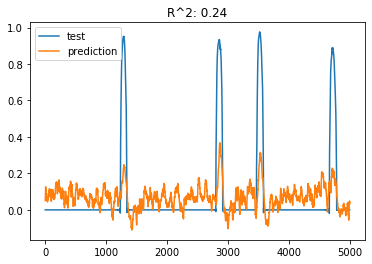

In [27]:
plt.plot(tr[0][:5000], label="test")
plt.plot(pr_tr[0][:5000], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[0], pr_tr[0]),2)))
plt.legend()

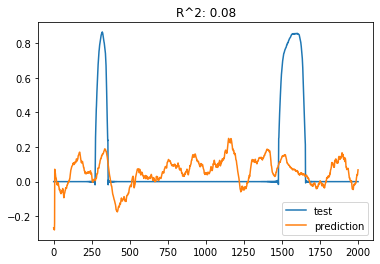

In [28]:
plt.plot(te[0][:2000], label="test")
plt.plot(pr_te[0][:2000], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[0], pr_te[0]),2)))
plt.legend()

In [81]:
stats.spearmanr(tr[0], pr_tr[0])

SpearmanrResult(correlation=-0.0041737700448473075, pvalue=0.37595732719393915)

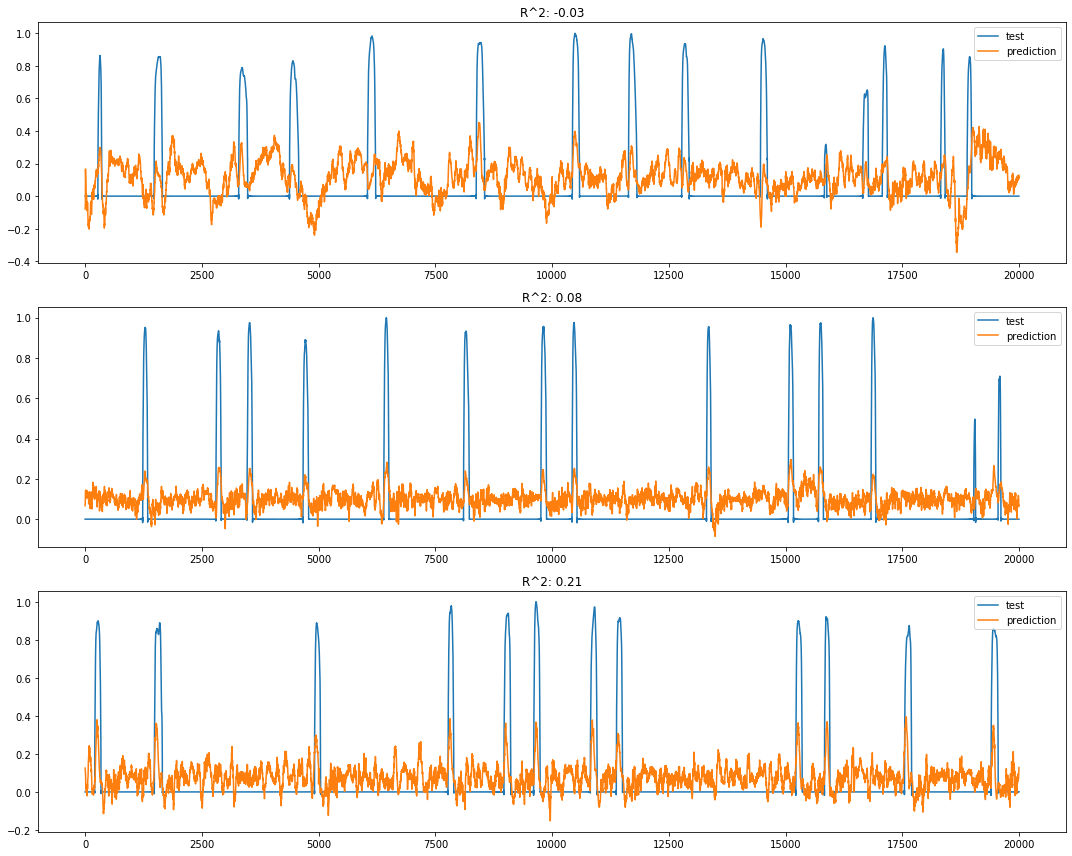

In [30]:
### Convnet
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(te[0][:20000], label="test")
plt.plot(pr_te[0][:20000], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[0], pr_te[0]),2)))
plt.legend()

plt.subplot(312)
plt.plot(te[1][:20000], label="test")
plt.plot(pr_te[1][:20000], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[1], pr_te[1]),2)))
plt.legend()

plt.subplot(313)
plt.plot(te[2][:20000], label="test")
plt.plot(pr_te[2][:20000], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[2], pr_te[2]),2)))
plt.legend()
plt.tight_layout()
plt.show()

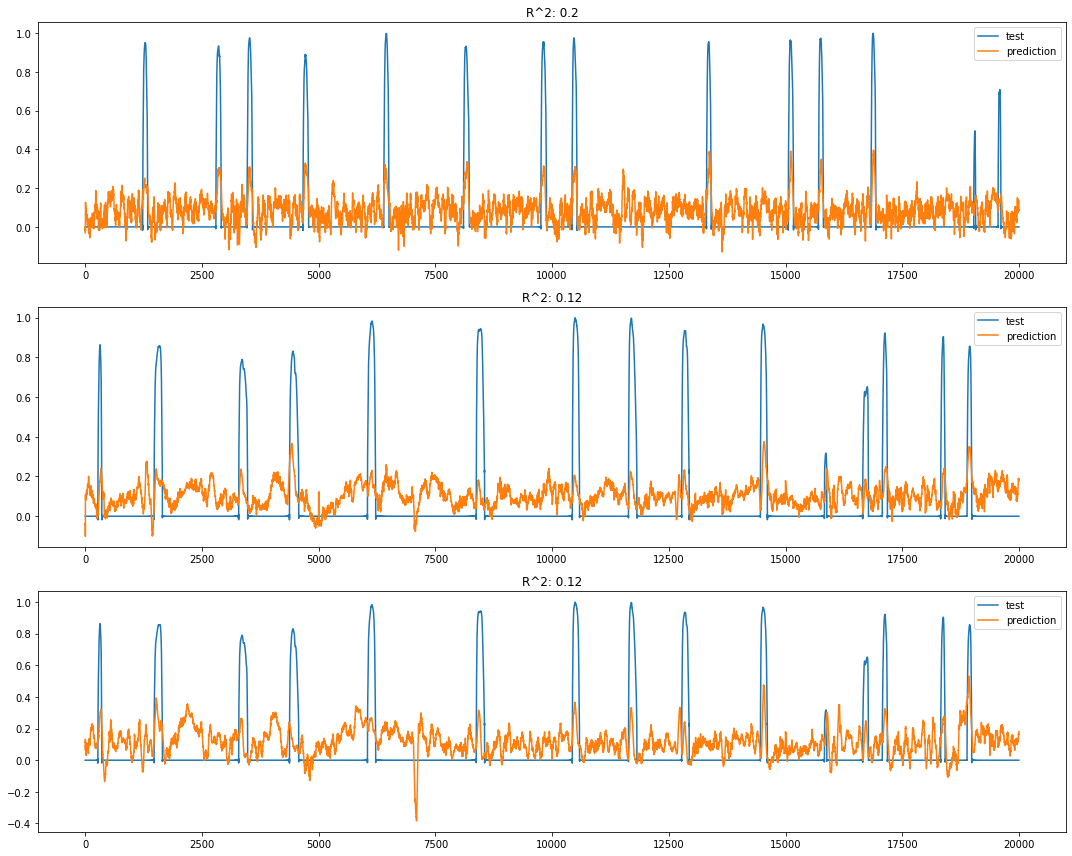

In [31]:
# Convnet
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(tr[0][:20000], label="test")
plt.plot(pr_tr[0][:20000], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[0], pr_tr[0]),2)))
plt.legend()

plt.subplot(312)
plt.plot(tr[1][:20000], label="test")
plt.plot(pr_tr[1][:20000], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[1], pr_tr[1]),2)))
plt.legend()

plt.subplot(313)
plt.plot(tr[2][:20000], label="test")
plt.plot(pr_tr[2][:20000], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[2], pr_tr[2]),2)))
plt.legend()
plt.tight_layout()
plt.show()

In [97]:
plt.plot(hist.history["correlation"], label="correlation")
plt.plot(hist.history["val_correlation"], label="val_correlation")
plt.legend()

KeyError: 'correlation'

### run nested CV

In [32]:
for sub in subjects:
    for loc in ["ECOG", "STN"]:
        for sess in ["right", "left"]:
            f_ = [file for file in vhdr_files if sub in file and sess in file]
            if len(f_) == 0:
                continue
            
            X, y_con, y_ips = get_data_raw_combined(sub, sess, loc, f_)
            
            # resample data
            y_con = signal.resample(y_con, int(y_con.shape[0]*fs_new / fs), axis=0)
            y_ips = signal.resample(y_ips, int(y_ips.shape[0]*fs_new / fs), axis=0)
            X = signal.resample(X, int(X.shape[1]*fs_new / fs), axis=1).T
            
            # write a function to normalize the data and 
            chans=X.shape[1]
            #X = X[:,::10].T # 6 channels, here downsampled to 500Hz!
            #y_con = y_con[::10] # read cleaned movement labels 
            #y_ips = y_ips[::10]
            
            Yp_tr= OrderedDict() # Y_predict_train
            sc_tr= OrderedDict() # score_train
            Yp_te= OrderedDict()
            sc_te= OrderedDict()
            Yt_tr= OrderedDict()
            Yt_te= OrderedDict()
            hist_ = OrderedDict()
            
            for lat in ["CON", "IPS"]:
                if lat == "CON": 
                    y_ = y_con
                else:
                    y_ = y_ips
                    
                print("RUNNING subject "+str(sub)+" sess: "+str(sess)+" lat: "+ str(lat)+ "loc: "+str(loc))
                score_te = []; score_tr = []
                pr_te = []; te = []; pr_tr = []; tr = []
                for train_index, test_index in cv.split(X):
                    X_train, X_test=X_here[train_index, :], X_here[test_index, :]
                    y_train, y_test=y_[train_index], y_[test_index]

                    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.7,shuffle=False)

                    #model  = DeepConvNet(Chans = chans, Samples = samples)
                    model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
                    model.compile(loss = "mae", optimizer = keras.optimizers.Adam(),\
                                  metrics=[correlation__])

                    es = EarlyStopping(monitor='val_correlation__', mode='max', verbose=1, patience=10)
                    mc = ModelCheckpoint('best_model.h5', monitor='val_correlation__', mode='max', verbose=1, save_best_only=True)

                    with tf.device('/gpu:0'):
                        gen_tr = generator_new(X_train, y_train, batch_size, chans, samples)
                        gen_val = generator_new(X_val, y_val, batch_size, chans, samples)
                        hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                                         epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
                    model = load_model('best_model.h5', custom_objects={'correlation_loss': correlation_loss,
                                                                        'correlation__': correlation__})

                    gen_ = generator_new(X_train, y_train, batch_size, chans, samples, keep_order=True)
                    pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
                    gen_ = generator_new(X_train, y_train, batch_size, chans, samples, keep_order=True)
                    y_train_ = get_label_from_gen(gen_, X_train, batch_size)

                    gen_ = generator_new(X_test, y_test, batch_size, chans, samples, keep_order=True)
                    pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
                    gen_ = generator_new(X_test, y_test, batch_size, chans, samples, keep_order=True)
                    y_test_ = get_label_from_gen(gen_, X_test, batch_size)

                    pr_tr.append(pr_train)
                    tr.append(y_train_)
                    pr_te.append(pr_test)
                    te.append(y_test_)
                    
                    sc = metrics.r2_score(pr_test, y_test_)
                    if sc < 0: sc = 0
                    print(sc)
                    print("score test: "+str(sc))
                    score_te.append(sc)
                    
                    sc = metrics.r2_score(pr_train, y_train_)
                    if sc < 0: sc = 0
                    print("score train: "+str(sc))
                    score_tr.append(sc)
                    
                    pr_tr.append(pr_train)
                    tr.append(y_train_)
                    pr_te.append(pr_test)
                    te.append(y_test_)
                    
                Yp_te[lat] = pr_te
                Yp_tr[lat] = pr_tr
                Yt_te[lat] = te
                Yt_tr[lat] = tr
                sc_te[lat] = np.mean(score_te)
                sc_tr[lat] = np.mean(score_tr)
                hist_[lat] = hist.history

            predict_ = {
                "y_pred_test": Yp_te,
                "y_test": Yt_te,
                "y_pred_train": Yp_tr,
                "y_train": Yt_tr,
                "score_tr": sc_tr,
                "score_te": sc_te,
                "hist": hist_
            }

            np.save(sub + "BestChpredictions_"+str(loc)+"-ses-"+str(sess)+".npy", predict_)

Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
RUNNING subject 000 sess: right lat: CONloc: ECOG
Train for 9 steps, validate for 3 steps
Epoch 1/100
8/9 [=========

Epoch 5/100
8/9 [=========================>....] - ETA: 0s - loss: 0.3016 - correlation__: 0.2357
Epoch 00005: val_correlation__ improved from 0.26288 to 0.35517, saving model to best_model.h5
9/9 [==============================] - 1s 153ms/step - loss: 0.3186 - correlation__: 0.2686 - val_loss: 0.2842 - val_correlation__: 0.3552
Epoch 6/100
8/9 [=========================>....] - ETA: 0s - loss: 0.3353 - correlation__: 0.2429
Epoch 00006: val_correlation__ improved from 0.35517 to 0.48195, saving model to best_model.h5
9/9 [==============================] - 1s 125ms/step - loss: 0.3199 - correlation__: 0.2132 - val_loss: 0.2782 - val_correlation__: 0.4820
Epoch 7/100
8/9 [=========================>....] - ETA: 0s - loss: 0.2552 - correlation__: 0.3074
Epoch 00007: val_correlation__ did not improve from 0.48195
9/9 [==============================] - 1s 119ms/step - loss: 0.2702 - correlation__: 0.3293 - val_loss: 0.2826 - val_correlation__: 0.4184
Epoch 8/100
8/9 [======================

Epoch 32/100
8/9 [=========================>....] - ETA: 9s - loss: 0.1199 - correlation__: 0.6316 
Epoch 00032: val_correlation__ did not improve from 0.62442
9/9 [==============================] - 86s 10s/step - loss: 0.1194 - correlation__: 0.5963 - val_loss: 0.2674 - val_correlation__: 0.3668
Epoch 33/100
8/9 [=========================>....] - ETA: 6s - loss: 0.1914 - correlation__: 0.5380
Epoch 00033: val_correlation__ did not improve from 0.62442
9/9 [==============================] - 79s 9s/step - loss: 0.1800 - correlation__: 0.5689 - val_loss: 0.2511 - val_correlation__: 0.4620
Epoch 34/100
8/9 [=========================>....] - ETA: 4s - loss: 0.1288 - correlation__: 0.6147
Epoch 00034: val_correlation__ did not improve from 0.62442
9/9 [==============================] - 39s 4s/step - loss: 0.1339 - correlation__: 0.5885 - val_loss: 0.2431 - val_correlation__: 0.4878
Epoch 35/100
8/9 [=========================>....] - ETA: 11s - loss: 0.1640 - correlation__: 0.5791
Epoch 0003

Epoch 8/100
8/9 [=========================>....] - ETA: 5s - loss: 0.3517 - correlation__: 0.2903 
Epoch 00008: val_correlation__ improved from 0.16992 to 0.20403, saving model to best_model.h5
9/9 [==============================] - 45s 5s/step - loss: 0.3270 - correlation__: 0.2725 - val_loss: 0.4621 - val_correlation__: 0.2040
Epoch 9/100
8/9 [=========================>....] - ETA: 3s - loss: 0.3248 - correlation__: 0.2765
Epoch 00009: val_correlation__ improved from 0.20403 to 0.22061, saving model to best_model.h5
9/9 [==============================] - 39s 4s/step - loss: 0.3461 - correlation__: 0.2867 - val_loss: 0.4871 - val_correlation__: 0.2206
Epoch 10/100
8/9 [=========================>....] - ETA: 0s - loss: 0.3198 - correlation__: 0.3280
Epoch 00010: val_correlation__ did not improve from 0.22061
9/9 [==============================] - 13s 1s/step - loss: 0.3034 - correlation__: 0.3287 - val_loss: 0.4692 - val_correlation__: 0.1726
Epoch 11/100
8/9 [=========================

Epoch 35/100
8/9 [=========================>....] - ETA: 4s - loss: 0.2377 - correlation__: 0.5688
Epoch 00035: val_correlation__ did not improve from 0.57609
9/9 [==============================] - 37s 4s/step - loss: 0.2369 - correlation__: 0.5756 - val_loss: 0.2997 - val_correlation__: 0.4367
Epoch 36/100
8/9 [=========================>....] - ETA: 9s - loss: 0.2117 - correlation__: 0.5487 
Epoch 00036: val_correlation__ did not improve from 0.57609
9/9 [==============================] - 76s 8s/step - loss: 0.2147 - correlation__: 0.5340 - val_loss: 0.3233 - val_correlation__: 0.3972
Epoch 37/100
8/9 [=========================>....] - ETA: 1s - loss: 0.2402 - correlation__: 0.5322
Epoch 00037: val_correlation__ did not improve from 0.57609
9/9 [==============================] - 16s 2s/step - loss: 0.2282 - correlation__: 0.5622 - val_loss: 0.3255 - val_correlation__: 0.4158
Epoch 38/100
8/9 [=========================>....] - ETA: 5s - loss: 0.2317 - correlation__: 0.5778 
Epoch 00038

Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...
RUNNING subject 000 sess: right lat: CONloc: STN
Train for 3 steps, validate for 1 steps
Epoch 1/100
2/3 [===================>..........] - ETA: 2s - loss: 0.6760 - correlation__: 0.0273
Epoch 00001: val_correlation__ improved from -inf to 0.15059, saving model to best_model.h5
3/3 [==============================] - 8s 3s/step - loss: 0.7098 - correlation__: 0.0645 - val_loss: 0.7560 - val_correlation__: 0.1506
Epoch 2/100
2/3 [===================>..........] - ETA: 1s - loss: 0.4503 - correlation__: 0.0699
Epoch 00002: val_correlation__ did not improve from 0.15059
3/3 [==============================] - 6s 2s/step - loss: 0.3432 - correlation__: 0.1426 - val_loss: 0.7450 - val_correlation__: 0.0879
Epoch 3/100
2/3 [===================

2/3 [===================>..........] - ETA: 1s - loss: 0.3479 - correlation__: 0.1067
Epoch 00029: val_correlation__ did not improve from 0.26777
3/3 [==============================] - 6s 2s/step - loss: 0.3478 - correlation__: 0.0581 - val_loss: 0.6411 - val_correlation__: 0.2668
Epoch 30/100
2/3 [===================>..........] - ETA: 1s - loss: 0.3757 - correlation__: 0.0558
Epoch 00030: val_correlation__ did not improve from 0.26777
3/3 [==============================] - 6s 2s/step - loss: 0.3268 - correlation__: 0.0017 - val_loss: 0.6388 - val_correlation__: 0.2658
Epoch 31/100
2/3 [===================>..........] - ETA: 1s - loss: 0.3463 - correlation__: 0.1099
Epoch 00031: val_correlation__ did not improve from 0.26777
3/3 [==============================] - 7s 2s/step - loss: 0.3428 - correlation__: 0.0702 - val_loss: 0.6365 - val_correlation__: 0.2669
Epoch 32/100
2/3 [===================>..........] - ETA: 1s - loss: 0.3720 - correlation__: 0.0576
Epoch 00032: val_correlation_

Epoch 8/100
2/3 [===================>..........] - ETA: 24s - loss: 0.3910 - correlation__: 0.0322
Epoch 00008: val_correlation__ improved from 0.31353 to 0.34925, saving model to best_model.h5
3/3 [==============================] - 79s 26s/step - loss: 0.3118 - correlation__: 5.3742e-04 - val_loss: 0.6464 - val_correlation__: 0.3492
Epoch 9/100
2/3 [===================>..........] - ETA: 25s - loss: 0.3666 - correlation__: 0.1153
Epoch 00009: val_correlation__ did not improve from 0.34925
3/3 [==============================] - 77s 26s/step - loss: 0.4502 - correlation__: 0.1649 - val_loss: 0.6449 - val_correlation__: 0.3422
Epoch 10/100
2/3 [===================>..........] - ETA: 24s - loss: 0.3886 - correlation__: 0.1002
Epoch 00010: val_correlation__ did not improve from 0.34925
3/3 [==============================] - 78s 26s/step - loss: 0.3122 - correlation__: 0.0485 - val_loss: 0.6452 - val_correlation__: 0.2975
Epoch 11/100
2/3 [===================>..........] - ETA: 21s - loss: 

IndexError: index 97408 is out of bounds for axis 0 with size 97408

In [5]:
dat = np.load("000BestChpredictions_STN-ses-right.npy", allow_pickle=True)

In [6]:
metrics.r2_score(dat.tolist()["y_test"]["CON"][1], dat.tolist()["y_pred_test"]["CON"][1])

-0.10445934417579106

In [14]:
metrics.r2_score(dat.tolist()["y_test"]["CON"][0], dat.tolist()["y_pred_test"]["CON"][0])

-0.10445934417579106

In [8]:
metrics.r2_score(dat.tolist()["y_test"]["CON"][2], dat.tolist()["y_pred_test"]["CON"][2])

-0.09418884247917658

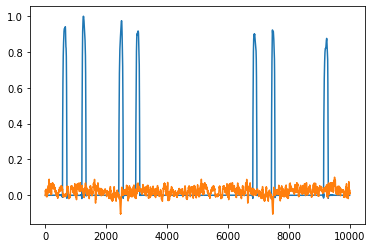

In [9]:
plt.plot(dat.tolist()["y_test"]["CON"][2][:10000])
plt.plot(dat.tolist()["y_pred_test"]["CON"][2][:10000])

In [10]:
stats.spearmanr(dat.tolist()["y_test"]["CON"][1], dat.tolist()["y_pred_test"]["CON"][1])

SpearmanrResult(correlation=0.06798651159310846, pvalue=1.0057568726617655e-11)

In [11]:
stats.spearmanr(dat.tolist()["y_test"]["CON"][2], dat.tolist()["y_pred_test"]["CON"][2])

SpearmanrResult(correlation=-0.04699894516524219, pvalue=2.577451648334684e-06)

In [12]:
stats.spearmanr(dat.tolist()["y_test"]["CON"][0], dat.tolist()["y_pred_test"]["CON"][0])

SpearmanrResult(correlation=0.06798651159310846, pvalue=1.0057568726617655e-11)

Text(0.5, 1.0, 'STN test sub000 con. $R^2$=0.0')

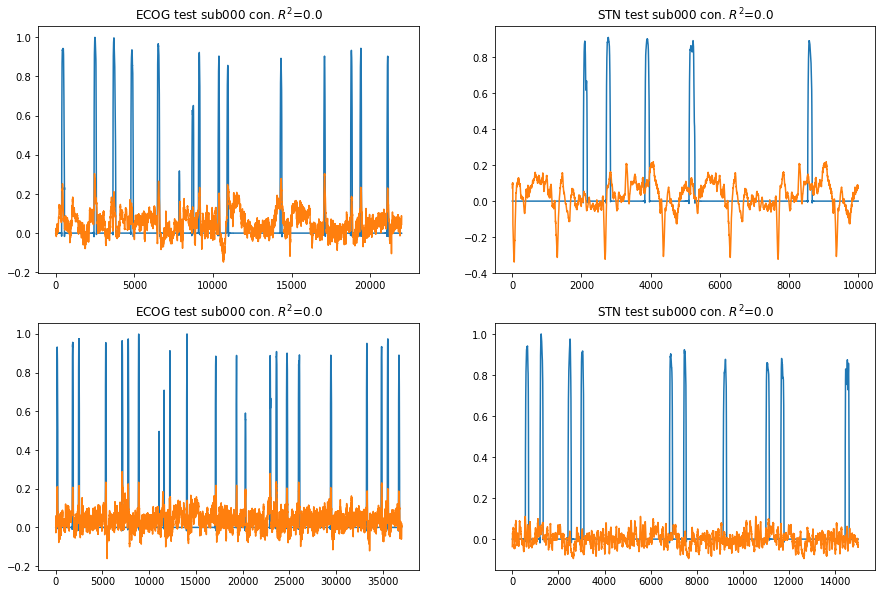

In [13]:
lat_ = "CON"
plt.figure(figsize=(15,10))
plt.subplot(221)
dat = np.load("000BestChpredictions_ECOG-ses-right.npy", allow_pickle=True)
plt.plot(dat.tolist()["y_test"]["CON"][1][8000:])
plt.plot(dat.tolist()["y_pred_test"]["CON"][1][8000:])
plt.title("ECOG test sub000 con. "+r"$R^2$" + "="+str(np.round(dat.tolist()["score_te"][lat_],2)))

plt.subplot(222)
dat = np.load("000BestChpredictions_STN-ses-right.npy", allow_pickle=True)
plt.plot(dat.tolist()["y_test"]["CON"][0])
plt.plot(dat.tolist()["y_pred_test"]["CON"][0])
plt.title("STN test sub000 con. "+r"$R^2$" + "="+str(np.round(dat.tolist()["score_te"][lat_],2)))

plt.subplot(223)
dat = np.load("000BestChpredictions_ECOG-ses-right.npy", allow_pickle=True)
plt.plot(dat.tolist()["y_train"]["CON"][0][8000:])
plt.plot(dat.tolist()["y_pred_train"]["CON"][0][8000:])
plt.title("ECOG test sub000 con. "+r"$R^2$" + "="+str(np.round(dat.tolist()["score_tr"][lat_],2)))

plt.subplot(224)
dat = np.load("000BestChpredictions_STN-ses-right.npy", allow_pickle=True)
plt.plot(dat.tolist()["y_train"]["CON"][0])
plt.plot(dat.tolist()["y_pred_train"]["CON"][0])
plt.title("STN test sub000 con. "+r"$R^2$" + "="+str(np.round(dat.tolist()["score_tr"][lat_],2)))

### test deepConvNet

In [6]:
sub = "000"
sess = "right"
lat = "CON"
loc = "ECOG"

f_ = [file for file in vhdr_files if sub in file and sess in file]
#if len(f_) == 0:
#    continue

X, y_con, y_ips = get_data_raw_combined(sub, sess, loc, f_)

# resample data
y_con = signal.resample(y_con, int(y_con.shape[0]*fs_new / fs), axis=0)
y_ips = signal.resample(y_ips, int(y_ips.shape[0]*fs_new / fs), axis=0)
X = signal.resample(X, int(X.shape[1]*fs_new / fs), axis=1).T

chans=X.shape[1]


Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-0_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-1_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-2_ieeg.vhdr...
Setting channel info structure...
Extracting parameters from C:\Users\ICN_admin\Dropbox (Brain Modulation Lab)\Shared Lab Folders\CRCNS\MOVEMENT DATA\sub-000\ses-right\ieeg\sub-000_ses-right_task-force_run-3_ieeg.vhdr...
Setting channel info structure...


In [7]:
X_norm = np.zeros(X.shape)
for i in range(X.shape[0]):
    if i == 0:
        X_norm[i,:] = X[i,:]
        continue
    if i < int(10*fs/fs_new):
        norm_ind_prev = np.arange(0, i, 1)
        X_norm[i,:] = (X[i,:] - np.median(X[norm_ind_prev,:], axis=0)) / np.median(X[norm_ind_prev,:], axis=0)
    else:
        norm_ind = np.arange(i-int(10*fs/fs_new),i, 1)
        X_norm[i,:] = (X[i,:] - np.median(X[norm_ind,:], axis=0)) / np.median(X[norm_ind,:], axis=0)
    

In [8]:
#X_z = stats.zscore(X, axis=0)

X_z = X_norm
X_z_ref = X_z
for i in range(X_z.shape[1]):
    ref = []
    for i_ in range(X_z.shape[1]):
        if i == i_:
            continue
        ref.append(X_z[:,i_])
    X_z_ref[:,i] -= np.array(ref).mean(axis=0)
X_z_ref = np.clip(X_z_ref, -3,3)

In [ ]:
X = X_z_ref
Yp_tr= OrderedDict() # Y_predict_train
sc_tr= OrderedDict() # score_train
Yp_te= OrderedDict()
sc_te= OrderedDict()
Yt_tr= OrderedDict()
Yt_te= OrderedDict()
hist_ = OrderedDict()

#for lat in ["CON", "IPS"]:
if lat == "CON": 
    y_ = y_con
else:
    y_ = y_ips

print("RUNNING subject "+str(sub)+" sess: "+str(sess)+" lat: "+ str(lat)+ "loc: "+str(loc))
score_te = []; score_tr = []
pr_te = []; te = []; pr_tr = []; tr = []
for train_index, test_index in cv.split(X):
    X_train, X_test=X[train_index, :], X[test_index, :]
    y_train, y_test=y_[train_index], y_[test_index]

    #X_train, X_test, y_train, y_test = train_test_split(X, y_, train_size=0.7,shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8,shuffle=False)


    #model  = DeepConvNet(Chans = chans, Samples = samples)
    model  = EEGNet(Chans = chans, Samples = samples, kernLength=kernLength)
    model.compile(loss = 'mse', optimizer = 'adam', metrics=[get_spearman_rankcor])

    es = EarlyStopping(monitor='val_get_spearman_rankcor', mode='max', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_get_spearman_rankcor', mode='max', verbose=1, save_best_only=True)

    with tf.device('/gpu:0'):
        gen_tr = generator_new(X_train, y_train, batch_size, chans, samples)
        gen_val = generator_new(X_val, y_val, batch_size, chans, samples)
        hist = model.fit(gen_tr, validation_data=gen_val, steps_per_epoch=int(X_train.shape[0]/batch_size), \
                         epochs=100, validation_steps=int(X_val.shape[0]/batch_size), callbacks=[es,mc])
    model = load_model('best_model.h5', custom_objects={'get_spearman_rankcor': get_spearman_rankcor})

    gen_ = generator_new(X_train, y_train, batch_size, chans, samples)
    pr_train = model.predict(gen_, steps=int(X_train.shape[0]/batch_size))[:,0]
    gen_ = generator_new(X_train, y_train, batch_size, chans, samples)
    y_train_ = get_label_from_gen(gen_, X_train, batch_size)

    gen_ = generator_new(X_test, y_test, batch_size, chans, samples)
    pr_test = model.predict(gen_, steps=int(X_test.shape[0]/batch_size))[:,0]
    gen_ = generator_new(X_test, y_test, batch_size, chans, samples)
    y_test_ = get_label_from_gen(gen_, X_test, batch_size)
    
    pr_tr.append(pr_train)
    tr.append(y_train_)
    pr_te.append(pr_test)
    te.append(y_test_)

RUNNING subject 000 sess: right lat: CONloc: ECOG
Train for 173 steps, validate for 43 steps
Epoch 1/100
170/173 [============================>.] - ETA: 0s - loss: 0.0443 - get_spearman_rankcor: 0.0077
Epoch 00001: val_get_spearman_rankcor improved from -inf to 0.01522, saving model to best_model.h5
173/173 [==============================] - 5s 31ms/step - loss: 0.0436 - get_spearman_rankcor: 0.0082 - val_loss: 0.0536 - val_get_spearman_rankcor: 0.0152
Epoch 2/100
  1/173 [..............................] - ETA: 2s - loss: 0.1839 - get_spearman_rankcor: 0.3071

### test set prediction

In [17]:
str(metrics.r2_score(te[0], pr_te[0]))

'0.005044262685240608'

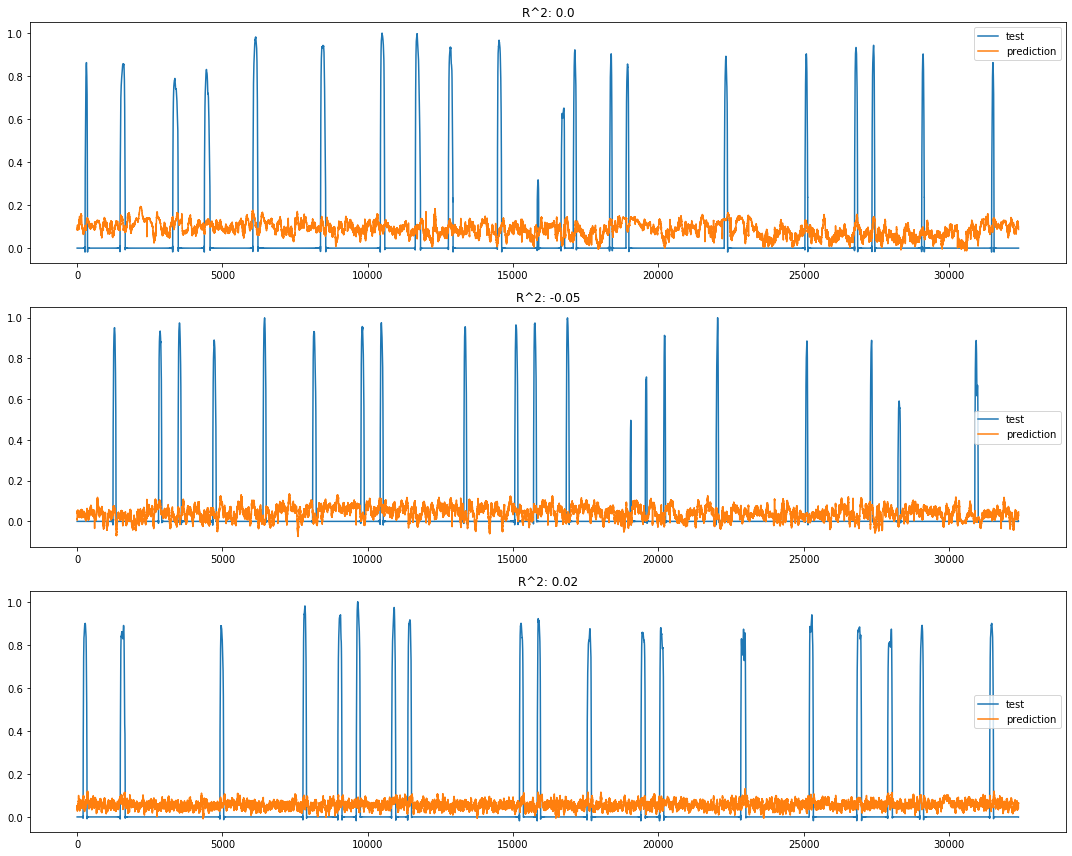

In [11]:
### Convnet
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(te[0], label="test")
plt.plot(pr_te[0], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[0], pr_te[0]),2)))
plt.legend()

plt.subplot(312)
plt.plot(te[1], label="test")
plt.plot(pr_te[1], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[1], pr_te[1]),2)))
plt.legend()

plt.subplot(313)
plt.plot(te[2], label="test")
plt.plot(pr_te[2], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[2], pr_te[2]),2)))
plt.legend()
plt.tight_layout()
plt.show()

### EEGnet

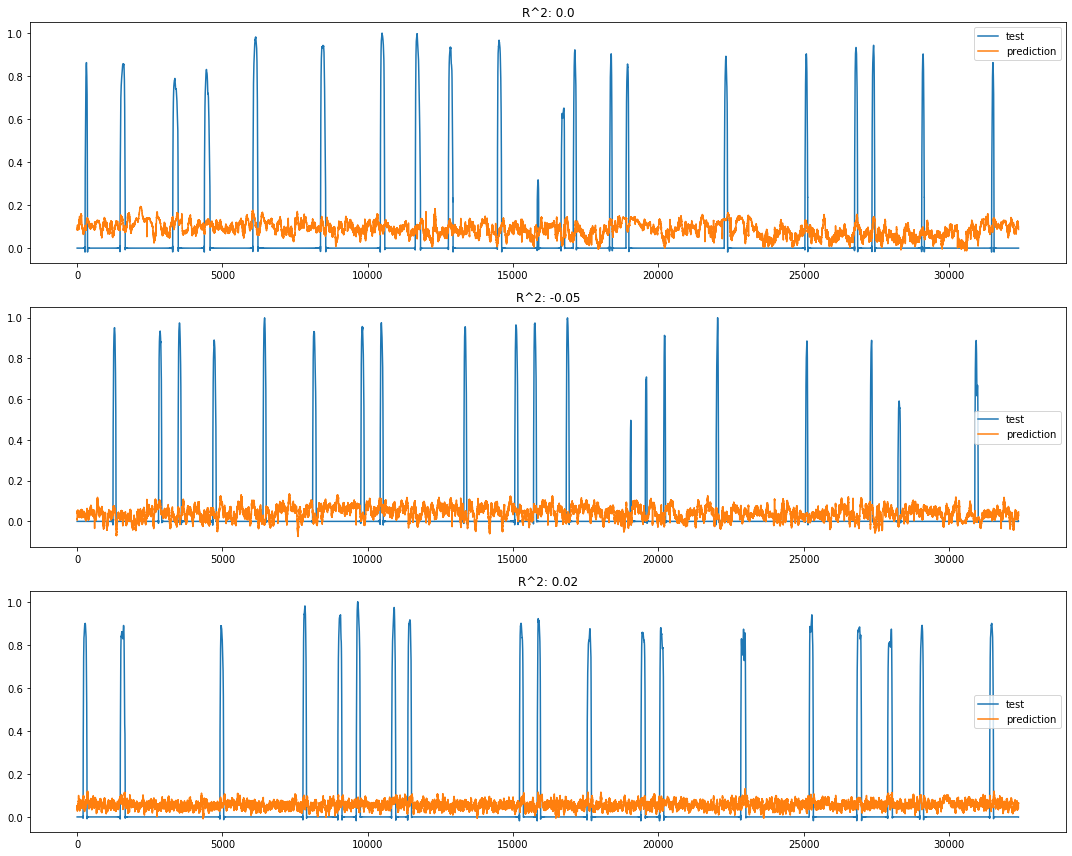

In [12]:
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(te[0], label="test")
plt.plot(pr_te[0], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[0], pr_te[0]),2)))
plt.legend()

plt.subplot(312)
plt.plot(te[1], label="test")
plt.plot(pr_te[1], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[1], pr_te[1]),2)))
plt.legend()

plt.subplot(313)
plt.plot(te[2], label="test")
plt.plot(pr_te[2], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(te[2], pr_te[2]),2)))
plt.legend()
plt.tight_layout()
plt.show()

### train set prediction

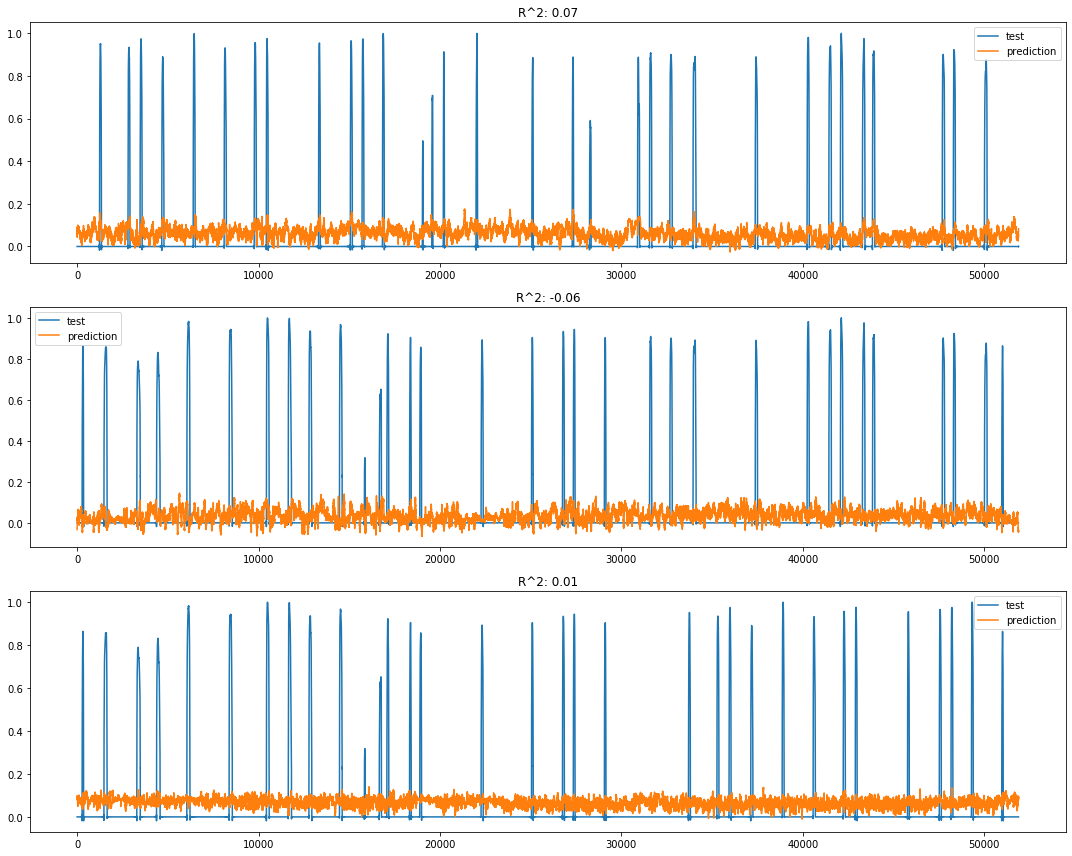

In [13]:
# Convnet
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(tr[0], label="test")
plt.plot(pr_tr[0], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[0], pr_tr[0]),2)))
plt.legend()

plt.subplot(312)
plt.plot(tr[1], label="test")
plt.plot(pr_tr[1], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[1], pr_tr[1]),2)))
plt.legend()

plt.subplot(313)
plt.plot(tr[2], label="test")
plt.plot(pr_tr[2], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[2], pr_tr[2]),2)))
plt.legend()
plt.tight_layout()
plt.show()

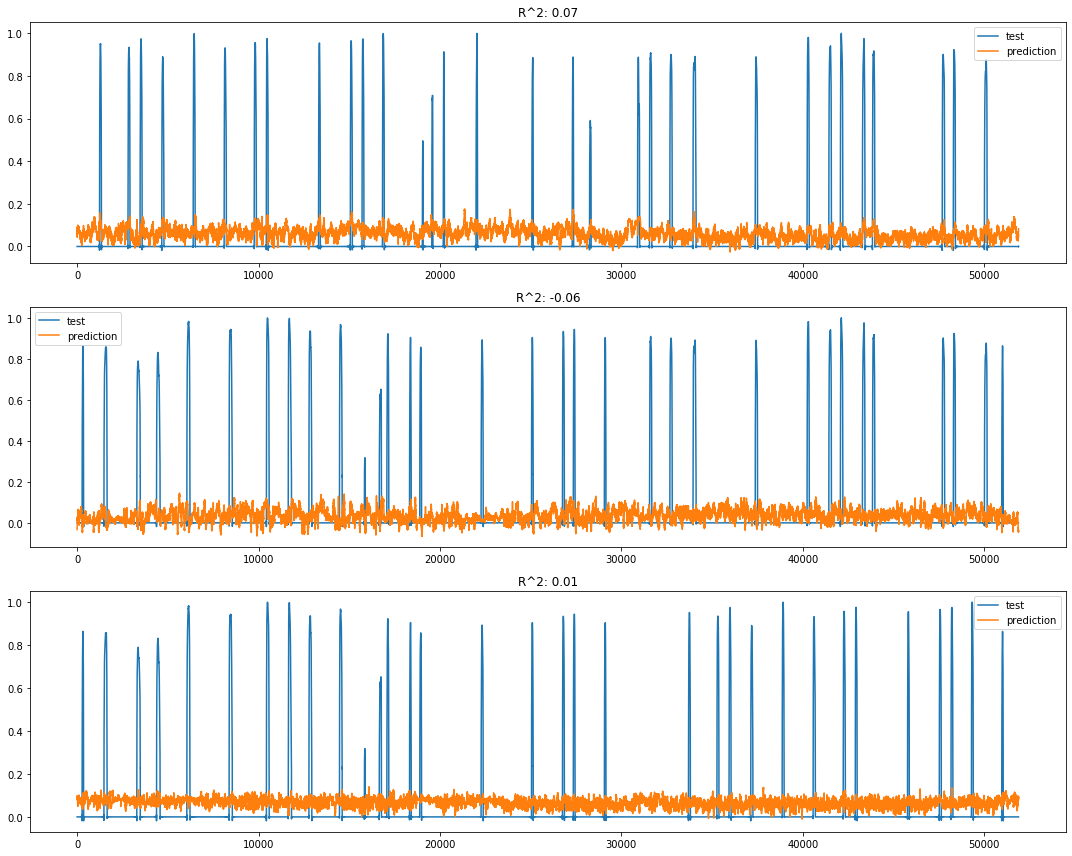

In [14]:
# EEGNET
plt.figure(figsize=(15,12))
plt.subplot(311)
plt.plot(tr[0], label="test")
plt.plot(pr_tr[0], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[0], pr_tr[0]),2)))
plt.legend()

plt.subplot(312)
plt.plot(tr[1], label="test")
plt.plot(pr_tr[1], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[1], pr_tr[1]),2)))
plt.legend()

plt.subplot(313)
plt.plot(tr[2], label="test")
plt.plot(pr_tr[2], label="prediction")
plt.title("R^2: "+str(np.round(metrics.r2_score(tr[2], pr_tr[2]),2)))
plt.legend()
plt.tight_layout()
plt.show()

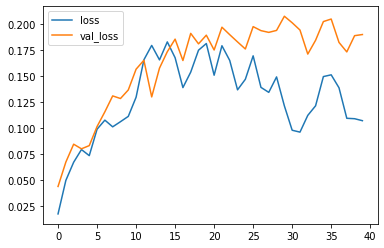

In [71]:
plt.plot(hist.history["correlation"], label="loss")
plt.plot(hist.history["val_correlation"], label="val_loss")
plt.legend()

In [69]:
hist.history

{'loss': [0.04792497688967617,
  0.03922755864914507,
  0.03540984917315128,
  0.03469891274138248,
  0.028924137113691725,
  0.031106164048918906,
  0.03145322345705003,
  0.030834210570901632,
  0.029301477519519274,
  0.033761197306021916,
  0.03490752917746023,
  0.03798560063908829,
  0.0402030209184738,
  0.03609366101587857,
  0.036396312988278924,
  0.03389820869015403,
  0.029516158092396157,
  0.028416960821508082,
  0.03082142108672075,
  0.03340814959487511,
  0.02859749179544155,
  0.03139374924537081,
  0.029676341664518033,
  0.027113723081886365,
  0.027914050582488702,
  0.028884732951431187,
  0.027465598925324453,
  0.02907247149714214,
  0.028376284448642757,
  0.02639544679129041,
  0.024162756166119567,
  0.025237230341976332,
  0.026913034485766825,
  0.028747941582248762,
  0.029758018550538876,
  0.030206481926669936,
  0.028266019411479878,
  0.02319997667210657,
  0.021655596963633526,
  0.023323082970349934],
 'correlation': [0.01749845,
  0.049741775,
  0.0